In [1]:
################################################################################################################################
#
# LSTM - JANSEN - MINMAX - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 4434.15 | Test RMSE: 6525.83'
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-MinMax')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-monthly'
#ESCALA = 'log'  #'minmax' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size = 6 # 63

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-28,16734.39
2000-02-29,17660.20
2000-03-31,17820.37
2000-04-28,15537.60
2000-05-31,14956.61
...,...
2023-08-31,115741.81
2023-09-29,116565.17
2023-10-31,113143.67


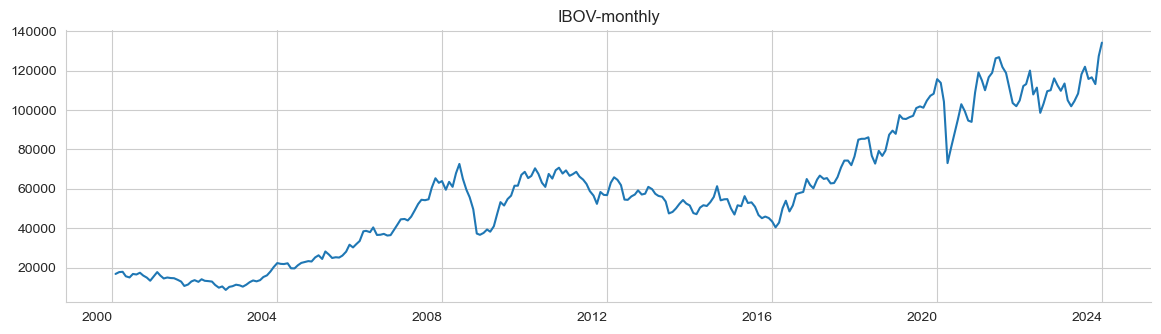

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: SCALE - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2022']).squeeze(), index=df[:'2022'].index)
df_scaled.describe()

count    276.000000
mean       0.398073
std        0.258634
min        0.000000
25%        0.191351
50%        0.389327
75%        0.513741
max        1.000000
dtype: float64

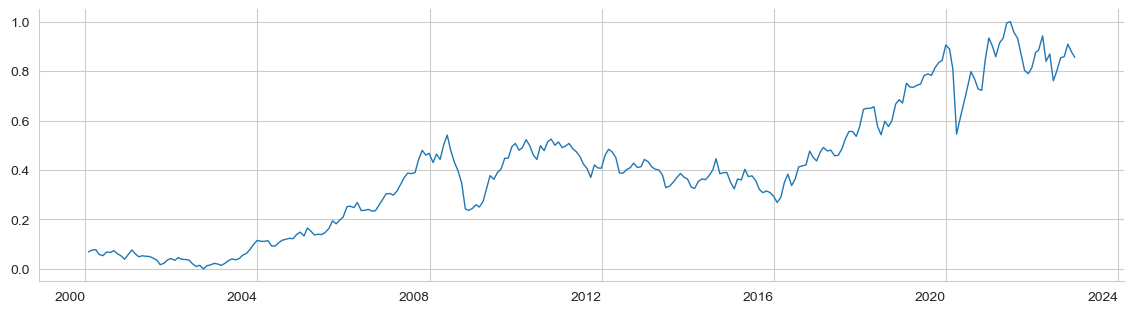

In [8]:
#===============================================================================================================================
# DATA: SCALE - TRAIN - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-07':]).squeeze(), index=df['2022-07':].index)
df_scaledtest

Date
2022-07-29    0.799990
2022-08-31    0.853792
2022-09-30    0.858140
2022-10-31    0.908913
2022-11-30    0.878865
2022-12-29    0.855583
2023-01-31    0.886857
2023-02-28    0.814944
2023-03-31    0.789138
2023-04-28    0.810711
2023-05-31    0.843741
2023-06-30    0.926259
2023-07-31    0.958887
2023-08-31    0.906415
2023-09-29    0.913382
2023-10-31    0.884430
2023-11-30    1.004480
2023-12-28    1.062478
dtype: float64

In [10]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [11]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5
Date,,,,,,
2000-07-31,0.068640,0.076474,0.077830,0.058513,0.053597,0.068586
2000-08-31,0.076474,0.077830,0.058513,0.053597,0.068586,0.066273
2000-09-29,0.077830,0.058513,0.053597,0.068586,0.066273,0.073822
2000-10-31,0.058513,0.053597,0.068586,0.066273,0.073822,0.061820
2000-11-30,0.053597,0.068586,0.066273,0.073822,0.061820,0.052841
...,...,...,...,...,...,...
2022-08-31,0.884415,0.942440,0.839857,0.869257,0.760874,0.799990
2022-09-30,0.942440,0.839857,0.869257,0.760874,0.799990,0.853792
2022-10-31,0.839857,0.869257,0.760874,0.799990,0.853792,0.858140


In [12]:
#===============================================================================================================================
# DATA: RESHAPE - TRAIN
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

In [13]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest


,0,1,2,3,4,5
Date,,,,,,
2023-01-31,0.799990,0.853792,0.858140,0.908913,0.878865,0.855583
2023-02-28,0.853792,0.858140,0.908913,0.878865,0.855583,0.886857
2023-03-31,0.858140,0.908913,0.878865,0.855583,0.886857,0.814944
2023-04-28,0.908913,0.878865,0.855583,0.886857,0.814944,0.789138
2023-05-31,0.878865,0.855583,0.886857,0.814944,0.789138,0.810711
2023-06-30,0.855583,0.886857,0.814944,0.789138,0.810711,0.843741
2023-07-31,0.886857,0.814944,0.789138,0.810711,0.843741,0.926259
2023-08-31,0.814944,0.789138,0.810711,0.843741,0.926259,0.958887
2023-09-29,0.789138,0.810711,0.843741,0.926259,0.958887,0.906415


In [14]:
#===============================================================================================================================
# DATA: PREP - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_test

(270, 6, 1) (270,) (12, 6, 1) (12,)


Date
2023-01-31    0.886857
2023-02-28    0.814944
2023-03-31    0.789138
2023-04-28    0.810711
2023-05-31    0.843741
2023-06-30    0.926259
2023-07-31    0.958887
2023-08-31    0.906415
2023-09-29    0.913382
2023-10-31    0.884430
2023-11-30    1.004480
2023-12-28    1.062478
dtype: float64

In [15]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(270, 6, 1)

In [16]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Monthly-MinMax-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

23/23 [==============================] - ETA: 0s - loss: 0.2515
Epoch 1: val_loss improved from inf to 0.60360, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 8s 81ms/step - loss: 0.2515 - val_loss: 0.6036
Epoch 2/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0969
Epoch 2: val_loss improved from 0.60360 to 0.22965, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 0s 11ms/step - loss: 0.0906 - val_loss: 0.2296
Epoch 3/150
18/23 [======================>.......] - ETA: 0s - loss: 0.0353
Epoch 3: val_loss improved from 0.22965 to 0.06936, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 0.0347 - val_loss: 0.0694
Epoch 4/150
16/23 [===================>..........] - ETA: 0s - loss: 0.0203
Epoch 4: val_loss improved from 0.06936 to 0.04162, saving model to Data

Epoch 34/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0031
Epoch 34: val_loss improved from 0.00441 to 0.00438, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 35/150
18/23 [======================>.......] - ETA: 0s - loss: 0.0029
Epoch 35: val_loss did not improve from 0.00438
23/23 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 36/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0031
Epoch 36: val_loss did not improve from 0.00438
23/23 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 37/150
17/23 [=====================>........] - ETA: 0s - loss: 0.0027
Epoch 37: val_loss did not improve from 0.00438
23/23 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 38/150
18/23 [======================>.......] - ETA: 0s - loss: 0.002

Epoch 70/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0024
Epoch 70: val_loss did not improve from 0.00382
23/23 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 71/150
18/23 [======================>.......] - ETA: 0s - loss: 0.0024
Epoch 71: val_loss did not improve from 0.00382
23/23 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch 72/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 72: val_loss did not improve from 0.00382
23/23 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 73/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 73: val_loss did not improve from 0.00382
23/23 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 74/150
23/23 [==============================] - ETA: 0s - loss: 0.0021
Epoch 74: val_loss improved from 0.00382 to 0.00382, saving model to Data/O

21/23 [==========================>...] - ETA: 0s - loss: 0.0017   
Epoch 106: val_loss did not improve from 0.00345
23/23 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 107/150
20/23 [=========================>....] - ETA: 0s - loss: 0.0017   
Epoch 107: val_loss improved from 0.00345 to 0.00339, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 108/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 108: val_loss improved from 0.00339 to 0.00339, saving model to Data/Output/Jansen-LSTM-MinMax\Monthly-MinMax-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 109/150
20/23 [=========================>....] - ETA: 0s - loss: 0.0017
Epoch 109: val_loss did not improve from 0.00339
23/23 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0034
Ep

19/23 [=======================>......] - ETA: 0s - loss: 0.0016
Epoch 141: val_loss did not improve from 0.00303
23/23 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 142/150
14/23 [=================>............] - ETA: 0s - loss: 0.0019
Epoch 142: val_loss did not improve from 0.00303
23/23 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 143/150
12/23 [==============>...............] - ETA: 0s - loss: 9.3065e-04
Epoch 143: val_loss did not improve from 0.00303
23/23 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 144/150
22/23 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 144: val_loss did not improve from 0.00303
23/23 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 145/150
10/23 [============>.................] - ETA: 0s - loss: 0.0011
Epoch 145: val_loss did not improve from 0.00303
23/23 [====================

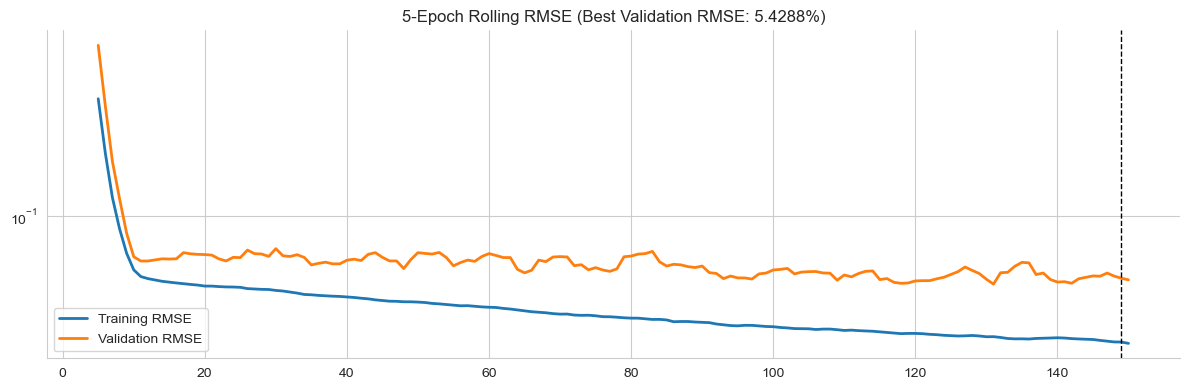

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

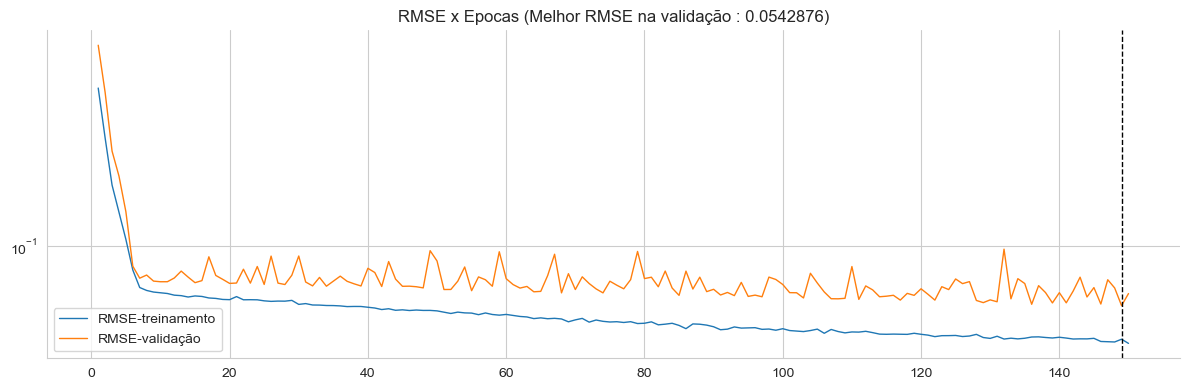

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0375 | Test RMSE: 0.0552
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0367 | Test RMSE: 0.0614


In [22]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 31ms/step


In [23]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.986859 | Test IC: 0.6434
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.986229 | Test IC: 0.6783


In [24]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
test_predict_scaled[:,0]

array([0.8478917 , 0.8729258 , 0.81493855, 0.78914624, 0.80385077,
       0.8319721 , 0.9029774 , 0.9353733 , 0.89522135, 0.89921725,
       0.8760305 , 0.97456485], dtype=float32)

In [25]:
#===============================================================================================================================
# RESULTS - SCALED - PRED - EXPORT
#===============================================================================================================================
#dftest_predict_scaled=test_predict_scaled.to_frame()
#dftest_predict_scaled.to_excel('Data/Output/LSTM-Jansen-Monthly-Scaled-Train.xlsx')
#dftest_predict_scaled
#test_predict_scaled.to_excel('Data/Output/LSTM-Jansen-Monthly-Scaled-Train.xlsx')
np.savetxt('Data/Output/LSTM-Jansen-Monthly-MinMax-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Monthly-MinMax-Scaled-Test.txt' , test_predict_scaled , delimiter=';')


In [26]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict  = pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze() , index=y_test.index )

test_predict

Date
2023-01-31    108825.632812
2023-02-28    111784.148438
2023-03-31    104931.257812
2023-04-28    101883.148438
2023-05-31    103620.914062
2023-06-30    106944.273438
2023-07-31    115335.617188
2023-08-31    119164.125000
2023-09-29    114419.015625
2023-10-31    114891.242188
2023-11-30    112151.054688
2023-12-28    123795.757812
dtype: float32

In [27]:
#===============================================================================================================================
# RESULTS - PRICE - PRED - EXPORT
#===============================================================================================================================
dftest_predict=test_predict.to_frame()
dftest_predict


,0
Date,
2023-01-31,108825.632812
2023-02-28,111784.148438
2023-03-31,104931.257812
2023-04-28,101883.148438
2023-05-31,103620.914062
2023-06-30,106944.273438
2023-07-31,115335.617188
2023-08-31,119164.125000
2023-09-29,114419.015625


In [28]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([113430.54, 104931.93, 101882.2 , 104431.63, 108335.07, 118087.  ,
       121942.98, 115741.81, 116565.17, 113143.67, 127331.12, 134185.24])

In [29]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 4434.15 | Test RMSE: 6525.83'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 4332.87 | Test RMSE: 7255.68'

In [30]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp['data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,111175.179688,NaN,111175.179688,Train
2023-01-31,113430.54,NaN,108825.632812,108825.632812,Test
2023-02-28,104931.93,NaN,111784.148438,111784.148438,Test
2023-03-31,101882.20,NaN,104931.257812,104931.257812,Test
2023-04-28,104431.63,NaN,101883.148438,101883.148438,Test
2023-05-31,108335.07,NaN,103620.914062,103620.914062,Test
2023-06-30,118087.00,NaN,106944.273438,106944.273438,Test
2023-07-31,121942.98,NaN,115335.617188,115335.617188,Test
2023-08-31,115741.81,NaN,119164.125000,119164.125000,Test


In [31]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Monthly-MinMax.xlsx')

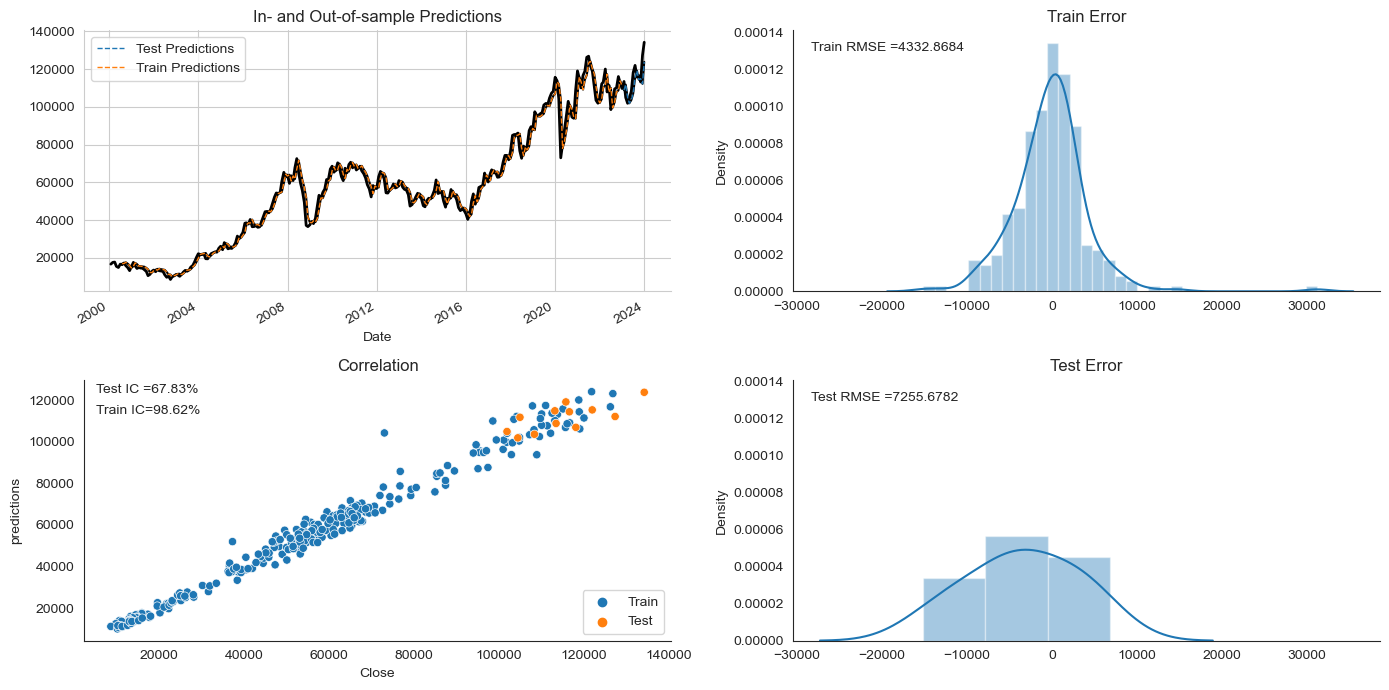

In [32]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
